### Neural Network with ReLU for Regression

In [17]:
import numpy as np
Wh = np.random.randn(1, 2) #/np.sqrt(1)
print (Wh)
print (Wh.shape)
print (np.max(Wh))
print (np.min(Wh))

[[ 0.04153939 -1.11792545]]
(1, 2)
0.0415393929984
-1.11792544511


In [18]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork():
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        self.inputLayerSize = inputLayerSize 
        self.hiddenLayerSize = hiddenLayerSize 
        self.outputLayerSize = outputLayerSize 
        
        # Initialize Weights
        self.Wh = np.random.randn(inputLayerSize, hiddenLayerSize)/np.sqrt(inputLayerSize)
        self.Wo = np.random.randn(hiddenLayerSize, outputLayerSize)/np.sqrt(hiddenLayerSize)
        #print  ("Weights: ",self.Wh,self.Wo)
        
        # Initialize Biases
        # Small positive value to avoid Relu units dying too quickly
        # http://cs231n.github.io/neural-networks-2/
        self.Bh = np.full((1, hiddenLayerSize), 0.2)
        self.Bo = np.full((1, outputLayerSize), 0.2)
        #print ("Biases: ",self.Bh,self.Bo)
        
        # Normalized Data Range
        self.minNorm = 0
        self.maxNorm = 1
        
        # Weighted Inputs
        self.Zh = None
        self.Zo = None
        
        # Activations
        self.Ah = None
        self.Ao = None
        
        # Logging
        self.log_interval = 1000
        
    def normalize(self, X, newMin, newMax):
        curMin = np.amin(X, axis=0)
        curMax = np.amax(X, axis=0)
        curRange = (curMax - curMin)  
        newRange = (newMax - newMin)
        return (((X - curMin) * newRange) / curRange) + newMin

    def denormalize(self, normalized, oldMin, oldMax):
        return self.normalize(normalized, oldMin, oldMax)

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_grad(self,z):
        #dr/dz = 1(z>0)
        grad = np.copy(z)
        grad[z <= 0] = 0
        grad[z > 0] = 1
        return grad
    
    def cost(self, output, y):
        cost = np.sum((output-y)**2) / 2.0
        return cost
    
    def cost_grad(self, output, y):
        return output - y
    
    def dCdW(self, layer_input, layer_error):
        #Derivative of Cost with respect to any weight in the network
        return np.dot(layer_input.T, layer_error)
            
    def dCdB(self, curLayerError):
        #Derivative of Cost with respect to the Bias of any neuron in the network
        '''
        CurLayerError has one row for each observation in our training set.
        This is fine for dCdW because the matrix multiplication takes
        care of transforming the output into dimensions that
        equal our weight dimensions (so we can subtract).
        However bias isn't multiplied by anything so we're stuck with 
        the dimensions of the output error. To fix this take the sum of
        all the output errors across observations (we could also take the average
        but our learning rate will handle scaling this value appropriately).
        The operation below sums all the values in a matrix on the row axis (0).
        It's essentially like summing all the rows into a single row. The column
        dimensions remain unchanged.
        '''
        return np.sum(curLayerError, axis=0, keepdims=True)
    
    def feed_forward(self, X):
        self.Zh = np.dot(X, self.Wh) + self.Bh
        self.Ah = self.relu(self.Zh)
        self.Zo = np.dot(self.Ah, self.Wo) + self.Bo
        self.Ao = self.Zo #Last layer is linear -no activation
        return self.Ao
    
    def backprop(self, X, output, y):
        err_output = self.cost_grad(output, y) #last layer is linear, no gradient needed
        err_hidden = np.dot(err_output, self.Wo.T) * self.relu_grad(self.Zh)

        # Weight Gradients
        dCdWh = self.dCdW(X, err_hidden)
        dCdWo = self.dCdW(self.Ah, err_output)
        
        # Bias Gradients
        dCdBh = self.dCdB(err_hidden)
        dCdBo = self.dCdB(err_output)

        return dCdWh, dCdWo, dCdBh, dCdBo
    
    def update_weights(self, X, y, lr):
        output = self.feed_forward(X)
        dCdWh, dCdWo, dCdBh, dCdBo = self.backprop(X, output, y)
        
        # Update Weights
        self.Wh -= lr * dCdWh
        self.Wo -= lr * dCdWo
        
        # Update Biases
        self.Bh -= lr * dCdBh
        self.Bo -= lr * dCdBo
    
        cost = self.cost(output, y)
        return cost

    def train(self, X, y, epochs, lr, log_interval):
        self.log_interval=log_interval
        X = self.normalize(X, self.minNorm, self.maxNorm)
        y = self.normalize(y, self.minNorm, self.maxNorm)
        cost_history = []
        for epoch in range(1,epochs+1):
            self.log("Epoch %d ---------------" % epoch, epoch)
            cost = self.update_weights(X, y, lr)
            cost_history.append(cost)
            msg = "Cost:" + str(round(cost,5)) + "\n"
            self.log(msg, epoch)
#             self.log("Weights:" + str(self.Wh) + str(self.Wo), epoch)
            #self.log("Ao" + str(self.Ao), epoch)
        return cost_history
    
    def predict(self, X, y_min, y_max):
        normalized_input = self.normalize(X, self.minNorm, self.maxNorm)
        output = self.feed_forward(normalized_input)
        denormalized_output = self.denormalize(output, y_min, y_max)
        return denormalized_output
    
    def log(self, msg, epoch):
        if epoch == 1 or epoch % self.log_interval == 0:
            print(msg)        

### Visualize

In [19]:
def graph(x, y, xlabel="X", ylabel="Y", title="X vs Y"):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def graph_error(error_history):
    iterations = [i for i in range(1,len(error_history)+1)]
    plt.plot(iterations, error_history)
    plt.title('Error Rate')
    plt.xlabel('Training Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()

### Load Data

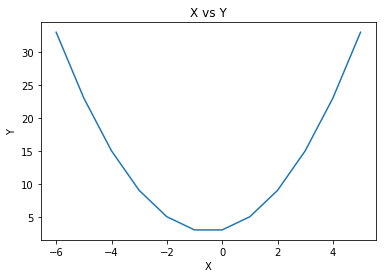

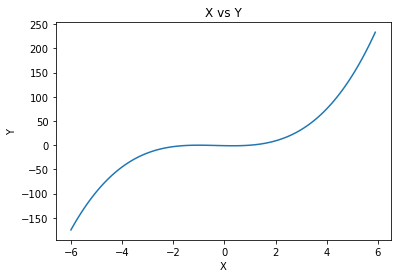

In [20]:
def quadratic(x):
    return x**2 + x + 3

def get_quadratic_data(start,end,step_size=1):
    X = np.array([i for i in np.arange(start,end,step_size)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([quadratic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y

def cubic(x):
    return x**3 + x**2 - x - 1

def get_cubic_data(start,end,step_size=1):
    X = np.array([i for i in np.arange(start,end,step_size)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([cubic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y


qX, qy = get_quadratic_data(-6,6)
graph(qX,qy)

cX, cy = get_cubic_data(-6,6,.1)
graph(cX,cy)

In [21]:
epochs = 5
for epoch in range(epochs):
    print (epoch)

0
1
2
3
4


### Training

In [22]:
np.random.seed(2)
X,y = get_quadratic_data(-20,21)
X,y = get_cubic_data(-20,21)

#ReLU needs more starting neurons b/c some will "die" 
nn = NeuralNetwork(1,6,1)

Epoch 1 ---------------
Cost:14.05471

Epoch 10000 ---------------
Cost:0.10074

Epoch 20000 ---------------
Cost:0.09512

Epoch 30000 ---------------
Cost:0.09174

Epoch 40000 ---------------
Cost:0.08827

Epoch 50000 ---------------
Cost:0.0846

Epoch 60000 ---------------
Cost:0.08071

Epoch 70000 ---------------
Cost:0.0766

Epoch 80000 ---------------
Cost:0.07232

Epoch 90000 ---------------
Cost:0.06793

Epoch 100000 ---------------
Cost:0.06348

Epoch 110000 ---------------
Cost:0.05901

Epoch 120000 ---------------
Cost:0.05452

Epoch 130000 ---------------
Cost:0.05013

Epoch 140000 ---------------
Cost:0.04589

Epoch 150000 ---------------
Cost:0.04192

Epoch 160000 ---------------
Cost:0.03829

Epoch 170000 ---------------
Cost:0.03503

Epoch 180000 ---------------
Cost:0.03206

Epoch 190000 ---------------
Cost:0.02934

Epoch 200000 ---------------
Cost:0.02687



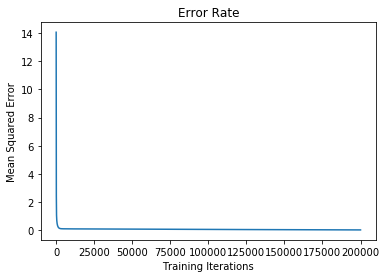

In [23]:
cost_hist = nn.train(X, y, epochs=200000, lr=.0001, log_interval=10000)
graph_error(cost_hist)

In [24]:
start,end = (-20,20)

#Quadratic
X,y = get_quadratic_data(start,end)
output = nn.predict(X,y_min=0,y_max=quadratic(max(abs(start), abs(end))))

#Cubic
X,y = get_cubic_data(start, end)
output = nn.predict(X,y_min=cubic(start), y_max=cubic(end))

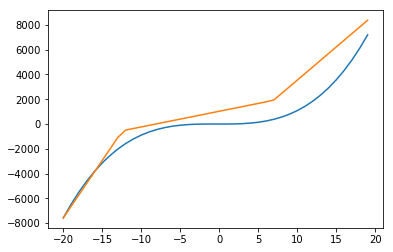

In [25]:
plt.plot(X,y)
plt.plot(X,output)
plt.show()

### How Does Number of Neurons Impact Learning?

In [1315]:
np.random.seed(2)

epochs = 200000
learning_rate = .0001
costs = {}
cost_histories = {}
predictions = {}
networks = {}
neurons = [3,6,20,100]
for n in neurons:
    start,end = (-20,21)
    X,y = get_cubic_data(start,end)
    nn = NeuralNetwork(1,n,1)
    networks[n] = nn
    cost_histories[n] = nn.train(X, y, epochs=epochs, lr=learning_rate, log_interval=50000)
    
    X,y = get_cubic_data(-10,10)
    predictions[n] = nn.predict(X,y_min=cubic(start), y_max=cubic(end))
    costs[n] = math.log(nn.cost(X, predictions[n], y))

Epoch 1 ---------------
Cost:4.68752

Epoch 50000 ---------------
Cost:0.10273

Epoch 100000 ---------------
Cost:0.10235

Epoch 150000 ---------------
Cost:0.10214

Epoch 200000 ---------------
Cost:0.10201

Epoch 1 ---------------
Cost:3.21028

Epoch 50000 ---------------
Cost:0.10587

Epoch 100000 ---------------
Cost:0.10378

Epoch 150000 ---------------
Cost:0.10263

Epoch 200000 ---------------
Cost:0.09994

Epoch 1 ---------------
Cost:2.2018

Epoch 50000 ---------------
Cost:0.0644

Epoch 100000 ---------------
Cost:0.03713

Epoch 150000 ---------------
Cost:0.02208

Epoch 200000 ---------------
Cost:0.01395

Epoch 1 ---------------
Cost:2.73806

Epoch 50000 ---------------
Cost:0.03478

Epoch 100000 ---------------
Cost:0.01597

Epoch 150000 ---------------
Cost:0.00897

Epoch 200000 ---------------
Cost:0.00588



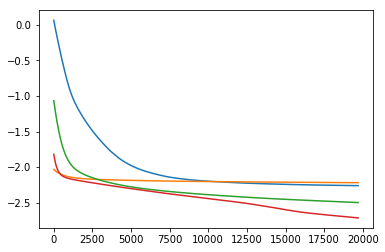

In [1316]:
plt.plot(np.log(cost_histories[3][300:20000]))
plt.plot(np.log(cost_histories[6][300:20000]))
plt.plot(np.log(cost_histories[20][300:20000]))
plt.plot(np.log(cost_histories[100][300:20000]))
plt.show()

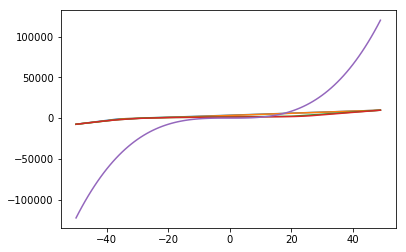

In [1317]:
plt.plot(X,predictions[3])
plt.plot(X,predictions[6])
plt.plot(X,predictions[20])
plt.plot(X,predictions[100])
plt.plot(X,y)
plt.show()

### Scikit-Learn Example

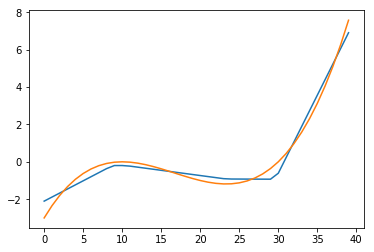

In [1422]:
from sknn.mlp import Regressor
from sknn.mlp import Layer

# Design Network
hiddenLayer = Layer("Rectifier", units=6)
outputLayer = Layer("Linear", units=1)
nn = Regressor([hiddenLayer, outputLayer], learning_rule='sgd',
               learning_rate=.001,batch_size=5,loss_type="mse")

# Train Model
X,y = get_cubic_data(-2,2,.1)
nn.fit(X,y)

# Predict
predictions = nn.predict(X)

# Visualize
plt.plot(predictions)
plt.plot(y)
plt.show()

In [1423]:
nn.get_parameters()

[Parameters(weights=array([[ 0.53861075,  0.07695764, -1.19058596,  2.45308343,  0.59022941,
         0.5929086 ]]), biases=array([-0.17245001, -0.14660981, -1.33888264, -2.35898558, -0.20223226,
        0.56735499]), layer='hidden0'),
 Parameters(weights=array([[ 0.48303523],
       [-0.24537579],
       [-1.82607692],
       [ 3.41004184],
       [ 0.4742989 ],
       [-0.94205058]]), biases=array([-0.19954963]), layer='output')]

### Universal Function Approximation Code

In [1393]:
'''
Update the predict function in the NN class above to be:

def predict(self, X, y_min, y_max):
    return self.feed_forward(X)
'''

np.random.seed(3)

nn = NeuralNetwork(1,6,1)

print ("Weights")
print (nn.Wh.shape)
print (nn.Wo.shape)

hiddenWeights = np.array([
    [-5.0, -1.2, 1.2, 1.2, 2.0, 5.0],
])

outputWeights = np.array([
    [-1.0],
    [-1.0],
    [-1.0],
    [1.0],
    [1.0],
    [1.0]
])


nn.Wh = hiddenWeights
nn.Wo = outputWeights

print (nn.Wh)
print (nn.Wo)

print ("Biases")
print (nn.Bh.shape)
print (nn.Bo.shape)

hiddenBias = np.array([
    [-7.7, -1.3, 1.0, -0.2, -1.1, -5.0]
])

outputBias = np.array([
    [-0.0]
])

nn.Bh = hiddenBias
nn.Bo = outputBias

print (nn.Bh)
print (nn.Bo)

#x**3 + x**2 - x - 1

X,y = get_cubic_data(-2,2,.1)
print (X.shape)
print (y.shape)
predictions = nn.predict(X,y_min=cubic(-2), y_max=cubic(2))

Weights
(1, 6)
(6, 1)
[[-5.  -1.2  1.2  1.2  2.   5. ]]
[[-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]]
Biases
(1, 6)
(1, 1)
[[-7.7 -1.3  1.  -0.2 -1.1 -5. ]]
[[-0.]]
(40, 1)
(40, 1)


### Predictions w My Weights

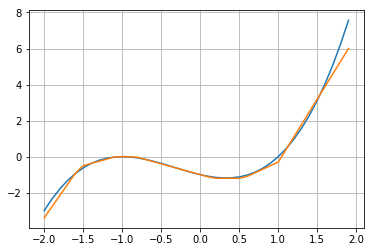

In [1394]:
fig, ax = plt.subplots()
ax.plot(X, y)
ax.plot(X, predictions)
ax.grid(True)
plt.show()